## Goal of this notebook

Copy the entire get_J_terms here.
See if we can close if we bin diffusion at the gateway T and S rather than the center T and S.

In [1]:
# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [2]:
from matplotlib.ticker import FuncFormatter, MaxNLocator

In [3]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times["2016"] = np.arange(1,3,1)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting

dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()
dt

2678400.0

In [4]:
tsstr

array(['0000736272', '0000740736'], dtype='<U32')

In [18]:
# we will hard code some example box with gates for now
xs = np.array([[25,26,27],[25,26,27],[25,26,27]])
ys = np.array([[525,525,525],[526,526,526],[527,527,527]])

xs = np.array([[25,26],[25,26],[25,26]])
ys = np.array([[525,525],[526,526],[527,527]])

# 10x10 grid continuing your pattern
xs = np.tile(np.arange(25, 35), (10, 1))                 # each row: 25..34
ys = np.tile(np.arange(525, 535).reshape(10, 1), (1, 10))  # each col: 525..534

xs = np.tile(np.arange(2, 36), (15, 1))                  # shape (15, 34)
ys = np.tile(np.arange(520, 535).reshape(15, 1), (1, 34))  # shape (15, 34)

xs = np.array([[25,26],[25,26]])
ys = np.array([[525,525],[526,526]])

# xs = np.array([[25],[25]])
# ys = np.array([[525,],[526,]])

print(xs.shape, ys.shape)   # (15, 34) (15, 34)

print(xs.shape, ys.shape)  # (10, 10) (10, 10)

gatei = np.nanmin(xs)
gateip1 = np.nanmax(xs)
gateip3 = np.nanmax(xs) + 1   # the eastern "gate" index for this range,  we take -advx
gatej = np.nanmin(ys)
gatejp1 = np.nanmin(ys) + 1   # the northern "gate" index we take at j+1 for -advy
gatejp2 = np.nanmax(ys) +1
gatejp2

print(gatei,gateip3)
print(gatej,gatejp2)
x1d = xs.ravel()  # or xs.flatten()
y1d = ys.ravel()

(2, 2) (2, 2)
(2, 2) (2, 2)
25 27
525 527


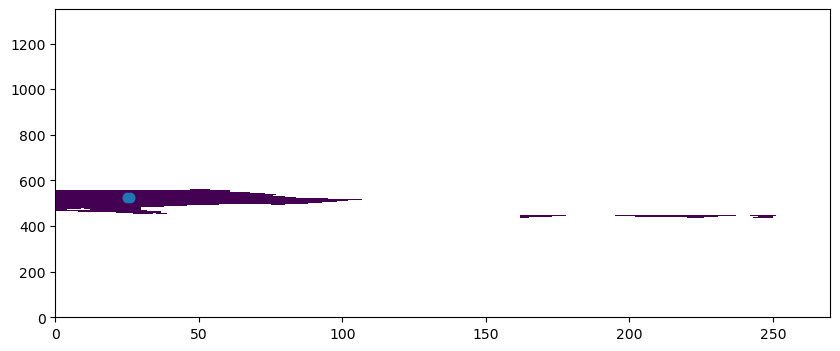

In [19]:
plt.pcolormesh(mymsk)
plt.scatter(xs,ys)
# plt.xlim(23,40)
# plt.ylim(520,540)

In [20]:
# --- allocate per-timestep volumes (if you want them) ---
vol = np.zeros((len(tsstr), nz, ny, nx))
for t in range(len(tsstr)):
    # DRF3d should be (nz, ny, nx); DXG/DYG are (ny, nx)
    tmpvol = (np.tile(mygrid['DXG'][None, :, :], (nz, 1, 1))
             * np.tile(mygrid['DYG'][None, :, :], (nz, 1, 1))
             * DRF3d)
    vol[t] = tmpvol * np.tile(mymsk, (nz, 1, 1))

print("doing TS binning")

# --- TS bin definitions (unchanged) ---
n_bins = 112
T_min, T_max = -2.0, 15.0
S_min, S_max = 28.0, 37.0

binsTH_edges   = np.linspace(T_min, T_max, n_bins + 1)
binsSLT_edges  = np.linspace(S_min, S_max, n_bins + 1)
binsTH_centers = 0.5 * (binsTH_edges[:-1]  + binsTH_edges[1:])
binsSLT_centers= 0.5 * (binsSLT_edges[:-1] + binsSLT_edges[1:])

nT = nS = n_bins

# optional helpers
Tbin,     Sbin     = np.meshgrid(binsTH_edges,   binsSLT_edges)
Tbincent, Sbincent = np.meshgrid(binsTH_centers, binsSLT_centers)
binwidthT = np.diff(binsTH_edges)
binwidthS = np.diff(binsSLT_edges)
dT, dS = np.meshgrid(binwidthT, binwidthS)
dT = dT.reshape(n_bins, n_bins, 1)
dS = dS.reshape(n_bins, n_bins, 1)
ts_pair = [int(tsstr[0]), int(tsstr[1])]

file_name = "state_3d_set1"
meta_state = parsemeta(os.path.join(dirState, f"{file_name}.{tsstr[0]}.meta"))
fldlist = np.array(meta_state["fldList"])
want = np.array(["THETA", "SALT"])
recs = np.array([np.where(fldlist == v)[0][0] for v in want])

# storage: float with NaN for out-of-range
binned_theta_ts   = np.full((2, nz, ny, nx), np.nan, dtype=float)
binned_salinity_ts= np.full((2, nz, ny, nx), np.nan, dtype=float)

for k, tstamp in enumerate(ts_pair):
    THETA, _, _ = rdmds(os.path.join(dirState, file_name), tstamp, returnmeta=True, rec=int(recs[0]))
    SALT,  _, _ = rdmds(os.path.join(dirState, file_name), tstamp, returnmeta=True, rec=int(recs[1]))

    THETA = THETA.reshape(nz, ny, nx) * np.tile(mymsk[None, :, :], (nz, 1, 1))
    SALT  = SALT.reshape(nz, ny, nx)  * np.tile(mymsk[None, :, :], (nz, 1, 1))

    # bin indices nan for outside
    bt = bin_array(THETA, binsTH_edges).astype(float)
    bs = bin_array(SALT,  binsSLT_edges).astype(float)

    # handle edges
    bt[(bt == nT) | (~np.isfinite(THETA))] = np.nan
    bs[(bs == nS) | (~np.isfinite(SALT ))] = np.nan

    binned_theta_ts[k]    = bt
    binned_salinity_ts[k] = bs

doing TS binning


In [21]:
binned_theta = binned_theta_ts[1]
binned_salinity = binned_salinity_ts[1]

In [22]:

# unique coords in order (assumes a rectilinear block)
x_vals = xs[0, :]          # [25, 26, 27]
y_vals = ys[:, 0]          # [525, 526, 527]

# infer spacing (fallback 1 if single cell)
dxs = np.unique(np.diff(x_vals))
dys = np.unique(np.diff(y_vals))
dx = dxs[0] if dxs.size else 1
dy = dys[0] if dys.size else 1

i_min, i_max = x_vals[0], x_vals[-1]
j_min, j_max = y_vals[0], y_vals[-1]

# gates (faces just outside the patch on right/top)
leftx  = np.full_like(y_vals, i_min)
lefty  = y_vals.copy()

rightx = np.full_like(y_vals, i_max + dx)
righty = y_vals.copy()

botx   = x_vals.copy()
boty   = np.full_like(x_vals, j_min)

topx   = x_vals.copy()
topy   = np.full_like(x_vals, j_max + dy)

print(leftx, lefty)
print(botx, boty)
print(rightx, righty)
print(topx, topy)

[25 25] [525 526]
[25 26] [525 525]
[27 27] [525 526]
[25 26] [527 527]


# 0) Load the budgeting terms

In [23]:
# read adv and dfe
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT","DFxE_SLT","DFyE_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
ADVx_SLT = ADVx_SLT.reshape(nz,ny,nx)
ADVy_SLT = ADVy_SLT.reshape(nz,ny,nx)
DFxE_SLT = DFxE_SLT.reshape(nz,ny,nx)
DFyE_SLT = DFyE_SLT.reshape(nz,ny,nx)

# read the vars
file_name = "budg2d_hflux_set1"
meta_budg2d_hflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_hflux_set1["fldList"])
varnames = np.array(["ADVxHEFF","ADVyHEFF","DFxEHEFF","DFyEHEFF"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVxHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVyHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
ADVxHEFF = ADVxHEFF.reshape(ny,nx)
ADVyHEFF = ADVxHEFF.reshape(ny,nx)
DFxEHEFF = DFxEHEFF.reshape(ny,nx)
DFyEHEFF = DFyEHEFF.reshape(ny,nx)


# read fluxes
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["oceSPflx","SFLUX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceSPflx,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
SFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPflx = oceSPflx.reshape(ny,nx)
SFLUX = SFLUX.reshape(ny,nx)

# read relax and salt mass
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceSflux","WSLTMASS","SRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WSLTMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
oceSflux = oceSflux.reshape(ny,nx)
WSLTMASS = WSLTMASS.reshape(ny,nx)
SRELAX = SRELAX.reshape(ny,nx)

# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["oceSPtnd","KPPg_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSPtnd,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPtnd = oceSPtnd.reshape(nz,ny,nx)
KPPg_SLT = KPPg_SLT.reshape(nz,ny,nx)

# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_SLT","DFrE_SLT","DFrI_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
ADVr_SLT = ADVr_SLT.reshape(nz,ny,nx)
DFrE_SLT = DFrE_SLT.reshape(nz,ny,nx)
DFrI_SLT = DFrI_SLT.reshape(nz,ny,nx)

In [24]:
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["THETADR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisTHETADR,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisTHETADR = thisTHETADR.reshape(nz,ny,nx)
    THETADR[i] = thisTHETADR

THETADR =  (THETADR[1, :, :,:] - THETADR[0, :,:, :]) / dt    # degC.m/

AB_gT = 0
tmptend=myparms['rcp']*(THETADR-AB_gT)*mk3D_mod(RAC,THETADR)   # J/m^3.degC * degC.m/s * m^2 = J/s
budgO = {}
budgO['heatfluxes'] = {}

budgO['heatfluxes']['tend'] = tmptend     # J/s

budgO['heattend'] = np.nansum(tmptend,axis=0)

file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH","DFxE_TH","DFyE_TH","UVELMASS","VVELMASS"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
UVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[4])
VVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[5])  # m/s
ADVx_TH = ADVx_TH.reshape(nz,ny,nx)
ADVy_TH = ADVy_TH.reshape(nz,ny,nx)
DFxE_TH = DFxE_TH.reshape(nz,ny,nx)
DFyE_TH = DFyE_TH.reshape(nz,ny,nx)
UVELMASS = UVELMASS.reshape(nz,ny,nx)
VVELMASS = VVELMASS.reshape(nz,ny,nx)


file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["TFLUX","oceQsw","SItflux"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
TFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
oceQsw,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SItflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
TFLUX = TFLUX.reshape(ny,nx)
oceQsw = oceQsw.reshape(ny,nx)
SItflux = SItflux.reshape(ny,nx)

# note: the following works provided that the first 3 terms are definitely there
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceQnet","WTHMASS","SIaaflux","TRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceQnet,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WTHMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SIaaflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
TRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
oceQnet = oceQnet.reshape(ny,nx)
WTHMASS = WTHMASS.reshape(ny,nx)
SIaaflux = SIaaflux.reshape(ny,nx)
TRELAX = TRELAX.reshape(ny,nx)

# note: will not work if these are defined, fix for future steps
varnames = np.array(["TRELAX","SIabflux","SIacflux","SIeprflx","SIfldflx"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])

# if len(recs) == 0:
SIabflux = np.zeros((ny, nx))
SIacflux = np.zeros((ny, nx))
SIeprflx = np.zeros((ny, nx))
SIfldflx = np.zeros((ny, nx))


# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["KPPg_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
KPPg_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_TH = KPPg_TH.reshape(nz,ny,nx)

# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_TH","DFrE_TH","DFrI_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
ADVr_TH = ADVr_TH.reshape(nz,ny,nx)
DFrE_TH = DFrE_TH.reshape(nz,ny,nx)
DFrI_TH = DFrI_TH.reshape(nz,ny,nx)

# 1) gateways -- TS volume inflow outflow

In [25]:
hFacW = mygrid['hFacW']
hFacS = mygrid['hFacS']

In [34]:
# copy the UVEL and VVEL calculation and grabbing of the gates here

# create the volume and bin this
DXG3d = np.tile(mygrid['DXG'][np.newaxis,:,:],(nz,1,1))
DYG3d = np.tile(mygrid['DYG'][np.newaxis,:,:],(nz,1,1))

# grab the UVEL and VVEL for this timestep
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["UVELMASS","VVELMASS"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
UVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
VVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])  # m/s
UVELMASS = UVELMASS.reshape(nz,ny,nx)
VVELMASS = VVELMASS.reshape(nz,ny,nx)
# this is where we try to put the salt terms into a TS mesh
# we need to go through the ADV points in each gate and add them to the TS bin at that point
binwidthTconst = np.nanmax(binwidthT)
binwidthSconst = np.nanmax(binwidthS)
norm = (binwidthTconst * binwidthSconst * myparms['rhoconst'])

J_gates = np.zeros((4,nS,nT))

#########################################################################################################################
for j,i in zip(lefty,leftx):
    # based on the direction, grab from ADV_gates at the correct index
    col = UVELMASS[:,j,i]

    nzc = len(binned_theta[:,j,i][~np.isnan(binned_theta[:,j,i])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta[kc,j,i])
        iSpt = int(binned_salinity[kc,j,i])
        J_gates[0,iSpt,iTpt] += (col[kc]) * DYG3d[kc,j,i] * DRF3d[kc,j,i]  / binwidthTconst  / binwidthSconst #m^3.PSU/s -- g/s -- 


#########################################################################################################################
# do this for bottom
for j,i in zip(boty,botx):
    # based on the direction, grab from ADV_gates at the correct index
    col = VVELMASS[:,j,i]
    nzc = len(binned_theta[:,j,i][~np.isnan(binned_theta[:,j,i])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta[kc,j,i])
        iSpt = int(binned_salinity[kc,j,i])
        J_gates[1,iSpt,iTpt] += (col[kc]) * DYG3d[kc,j,i] * DRF3d[kc,j,i] / binwidthTconst / binwidthSconst

#########################################################################################################################
# same for right
for j,i in zip(righty,rightx):
    # based on the direction, grab from ADV_gates at the correct index
    col = -UVELMASS[:,j,i]
    nzc = len(binned_theta[:,j,i-1][~np.isnan(binned_theta[:,j,i-1])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta[kc,j,i-1])
        iSpt = int(binned_salinity[kc,j,i-1])
        J_gates[2,iSpt,iTpt] += (col[kc]) * DYG3d[kc,j,i] * DRF3d[kc,j,i] / binwidthTconst / binwidthSconst

#########################################################################################################################
# same again for top
for j,i in zip(topy,topx):
    # based on the direction, grab from ADV_gates at the correct index
    col = -VVELMASS[:,j,i]
    nzc = len(binned_theta[:,j-1,i][~np.isnan(binned_theta[:,j-1,i])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta[kc,j-1,i])
        iSpt = int(binned_salinity[kc,j-1,i])
        J_gates[3,iSpt,iTpt] += (col[kc]) * DYG3d[kc,j,i] * DRF3d[kc,j,i] / binwidthTconst / binwidthSconst


#############################################################################################################################
J_gates *= 1e-6  # Sv

# 2) Surface freshwater T-S source

## Load the variables we need for the salt budget

In [35]:
# total tendency will just be for those two squares
print("doing salt budget")
# create the salt budget
AB_gT=0
AB_gS=0
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
# --- Read two snapshots and form dS/dt (PSU/s) ---
SALT_t = np.full((2, nz, ny, nx), np.nan)
for ii, tstr in enumerate(tsstr[:2]):
    myslt, its, meta = rdmds(os.path.join(dirIn, file_name),
                                  int(tstr), returnmeta=True, rec=recs[0])
    SALT_t[ii] = myslt.reshape(nz, ny, nx)

dSdt = (SALT_t[1] - SALT_t[0]) / dt   # PSU/s

# --- Cell volume (m^3) on C grid ---
# DRF: (nz,), RAC: (ny,nx), hFacC: (nz,ny,nx)
Vcell = mk3D_mod(mygrid['DRF'], dSdt) * mk3D_mod(RAC, dSdt) * mygrid['hFacC']  # m^3

# --- Salt "substance" tendency in PSU·m^3/s (for TS-volume view) ---
tmptend = dSdt * Vcell                 # PSU·m^3/s

# Pack outputs
budgO = {'saltfluxes': {}}
budgI = {'saltfluxes': {}}
budgOI = {}

budgO['saltfluxes']['tend'] = tmptend          # PSU·m^3/s
budgO['salttend']            = np.nansum(tmptend, axis=0)  # depth-sum PSU·m^3/s

doing salt budget


In [36]:
print("doing salt budget")

# read adv and dfe
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT","DFxE_SLT","DFyE_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])

tmpUo = (ADVx_SLT + DFxE_SLT)
tmpVo = (ADVy_SLT + DFyE_SLT)

# reshape and get the faces
tmpUo = tmpUo.reshape(nz,ny,nx)
tmpVo = tmpVo.reshape(nz,ny,nx)
tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
tmpVo = get_aste_faces(tmpVo,nfx,nfy)

budgO['saltfluxes']['hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)
budgO['salthconv'] = calc_UV_conv_mod(nfx,nfy,np.nansum(tmpUo,axis=0),np.nansum(tmpVo,axis=0))


# also do hconv for ADV and DF
tmpUo = get_aste_faces(ADVx_SLT.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(ADVy_SLT.reshape(nz,ny,nx),nfx,nfy)
budgO['saltfluxes']['ADV_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)    #  PSU.m^3/s

tmpUo = get_aste_faces(DFxE_SLT.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(DFyE_SLT.reshape(nz,ny,nx),nfx,nfy)
budgO['saltfluxes']['DF_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)     # PSU.m^3/s

# read the vars
file_name = "budg2d_hflux_set1"
meta_budg2d_hflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_hflux_set1["fldList"])
varnames = np.array(["ADVxHEFF","ADVyHEFF","DFxEHEFF","DFyEHEFF"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVxHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVyHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
ADVxHEFF = ADVxHEFF.reshape(ny,nx)
ADVyHEFF = ADVyHEFF.reshape(ny,nx)
DFxEHEFF = DFxEHEFF.reshape(ny,nx)
DFyEHEFF = DFyEHEFF.reshape(ny,nx)
    
if myparms['seaice_variable_salinity_flag'] == 0:
    SIsal0 = myparms['SIsal0']

if myparms["useRFWF"]==0 or myparms['useNLFS']==0:
    print('do nothing')
else:
    oceSflux = 0 * oceSflux

if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WSLTMASS=0*WSLTMASS

# FIX UNITS
budgO['saltzconv'] = (SFLUX + oceSPflx) / myparms['rhoconst'] * RAC                 # g/m^2/s * m^3/kg = PSU.m/s * RAC = PSU.m^3/s
zconv_top_salt = (SFLUX + oceSPflx) / myparms['rhoconst'] * RAC                     # g/m^2/s * m^3/kg * m^2 = PSU.m^3/s

if myparms['useNLFS']==0:
    budgO['saltzconv'] = budgO['saltzconv'] - (WSLTMASS * RAC)                      # PSU.m^3/s - (PSU.m/s * m^2) = PSU.m^3/s


nr = mygrid['RC'].shape[0]
# break trWtop down into smaller terms
trWtopADV = -(ADVr_SLT)                               # PSU.m^3/s
trWtopDF = -(DFrE_SLT+DFrI_SLT)                       # PSU.m^3/s
trWtopKPP = -(KPPg_SLT)                               # PSU.m^3/s
trWtop = trWtopADV + trWtopDF + trWtopKPP             # PSU.m^3/s

#print(trWtop.shape)
sptop = mk3D_mod(oceSPflx,oceSPtnd) - np.cumsum(oceSPtnd, axis=0)        # g/m^2/s - needs to be converted
sptop = sptop / myparms['rhoconst'] * RAC3        # g/m^2/s * m^3/kg * m^2 = PSU.m^3/s

trWtop[1:,:,:] = trWtop[1:,:,:] + sptop[:-1,:,:]                        # PSU.m^3/s
trWtop[0,:,:] = budgO['saltzconv']                                # PSU.m^3/s top layer is surface flux

trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:] = trWtop[1:,:,:]
trWbot[-1,:,:] = 0

budgO['saltfluxes']['trWtop'] = trWtop     # PSU.m^3/s
budgO['saltfluxes']['trWbot'] = trWbot     # PSU.m^3/s

budgO['saltfluxes']['zconv'] = budgO['saltfluxes']['trWtop'] - budgO['saltfluxes']['trWbot']  # PSU.m^3/s
budgO['saltzconv'] = budgO['saltzconv']   # PSU.m^3/s

# do vertical convergence for ADV and DF terms
tmpadv = np.full((nz,ny,nx),np.nan)
tmpadv[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])              # for surface thru seafloor

Sconv = budgO['saltfluxes']['ADV_hconv'] + tmpadv
budgO['saltfluxes']['ADV_Sconv'] = Sconv             # g/s, this is the advective arrow of S for a 

# do vertical convergence for ADV and DF terms
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])              # for surface thru seafloor

dfSconv = budgO['saltfluxes']['DF_hconv'] + tmpdf
budgO['saltfluxes']['DF_Sconv'] = dfSconv             # g/s, this is the diffusive arrow of T for a cell


tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]
budgO['saltfluxes']['KPP_Sconv'] = tmpkpp        # no horizontal component for this

print("doing JtermsS")
# initialize the J vectors for salt
JtermsS = np.zeros((5,nS,nT))

# get the values
aS = budgO['saltfluxes']['tend']  # g/s
bS = budgO['saltfluxes']['ADV_Sconv']
cS = budgO['saltfluxes']['DF_Sconv']
dS = budgO['saltfluxes']['KPP_Sconv']
eS = zconv_top_salt.reshape(1,ny,nx)
fS = sptop

for j,i in zip(y1d,x1d):

    # loop through the depths and add
    nzna = len(mygrid['hFacC'][:,j,i][~np.isnan(mygrid['hFacC'][:,j,i])]) # how many cells are filled here
    
    for k in range (nzna):
        iTpt = int(binned_theta[k,j,i])
        iSpt = int(binned_salinity[k,j,i])
    
        # save the J terms for here for the single point   
        JtendS = (aS[k,j,i]) / binwidthS[iSpt] * 1e-6             # PSU.m^3/s / PSU = Sv
        JADVS = (bS[k,j,i]) / binwidthS[iSpt] * 1e-6              # Sv
        JDFS = (cS[k,j,i]) / binwidthS[iSpt] * 1e-6               # Sv
        JKPPS = (dS[k,j,i]) / binwidthS[iSpt] * 1e-6              # Sv

        # surface term will be unique
        if k == 0:
            JsurfS = (eS[k,j,i] - fS[k+1,j,i]) / binwidthS[iSpt] * 1e-6  # Sv
        else:
            JsurfS = -(fS[k,j,i] - fS[k-1,j,i]) / binwidthS[iSpt] * 1e-6  # Sv

        # set these in meshes so we can plot
        c = 0
        for valS in (np.array([JtendS,JADVS,JDFS,JKPPS,JsurfS])):
            #print(valT)
            JtermsS[c,iSpt,iTpt] += valS
            c += 1

print("total resid: ",np.nansum(JtermsS[0] - JtermsS[1] - JtermsS[2] - JtermsS[3] - JtermsS[4]))

doing salt budget
doing JtermsS
total resid:  -0.36009091508069224


## Now we can try to make the theta budget based on the same principle

In [37]:
#############################################################################
print("doing heat budget")
# create the heat budget
# read thetadr
# --- read two THETA snapshots and form dT/dt (K/s) ---

file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["THETADR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
    
THETA_t = np.full((2, nz, ny, nx), np.nan)
for ii, tstr in enumerate(tsstr[:2]):
    tmpth, its, meta = rdmds(os.path.join(dirIn, 'budg3d_snap_set2'),
                                   int(tstr), returnmeta=True, rec=recs[0])  # rec for THETA, not THETADR
    THETA_t[ii] = tmpth.reshape(nz, ny, nx)

dTdt = (THETA_t[1] - THETA_t[0]) / dt     # K/s

# --- cell volume on C-grid (m^3) ---
Vcell = mk3D_mod(mygrid['DRF'], dTdt) * mk3D_mod(RAC, dTdt) * mygrid['hFacC']

# --- temperature "substance" tendency (°C·m^3/s) for TS-volume view ---
tmptend = dTdt * Vcell                    # K·m^3/s

budgO.setdefault('heatfluxes', {})
budgO['heatfluxes']['tend'] = tmptend     # K·m^3/s
budgO['heattend'] = np.nansum(tmptend, axis=0)  # depth-sum K·m^3/s

## do the advective convergence
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH","DFxE_TH","DFyE_TH","UVELMASS","VVELMASS"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])

tmpUo = (ADVx_TH + DFxE_TH)
tmpVo = (ADVy_TH + DFyE_TH)

tmpUo = tmpUo.reshape(nz,ny,nx)
tmpVo = tmpVo.reshape(nz,ny,nx)

# get the faces so we can do convergence
tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
tmpVo = get_aste_faces(tmpVo,nfx,nfy)

budgO['heatfluxes']['hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)
budgO['heathconv'] = calc_UV_conv_mod(nfx,nfy,np.nansum(tmpUo, axis=0),np.nansum(tmpVo,axis=0))

# add the budgeting for ADV and DF
tmpUo = get_aste_faces(ADVx_TH.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(ADVy_TH.reshape(nz,ny,nx),nfx,nfy)
budgO['heatfluxes']['ADV_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)  # keep in degC.m^3/s

tmpUo = get_aste_faces(DFxE_TH.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(DFyE_TH.reshape(nz,ny,nx),nfx,nfy)
budgO['heatfluxes']['DF_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)  # keep in degC.m^3/s

# note: will not work if these are defined, fix for future steps
varnames = np.array(["TRELAX","SIabflux","SIacflux","SIeprflx","SIfldflx"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])

# if len(recs) == 0:
SIabflux = np.zeros((ny, nx))
SIacflux = np.zeros((ny, nx))
SIeprflx = np.zeros((ny, nx))
SIfldflx = np.zeros((ny, nx))
if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WTHMASS=0*WTHMASS

geothFlux = 0
SPforcT1=0*np.ones((ny,nx))
oceEPtnd=0*np.ones((nz,ny,nx))

budgO['heatzconv']=(TFLUX+geothFlux+SPforcT1) / myparms['rcp'] * RAC    # W/m^2 = J/m^2/s * (m^3.degC/J) * m^2 = degC.m^3/s
zconv_top_heat = TFLUX / myparms['rcp'] * RAC                           # W/m^2 * m^2 * (m^3.degC/J) = degC.m^3/s
budgI['heatzconv']=-(SItflux+TFLUX-TRELAX+SPforcT1) / myparms['rcp'] * RAC   # W/m^2 = J/m^2/s * m^3.degC/J * m^2 = degC.m^3/s

budgI['heatzconv']=budgI['heatzconv']-SIabflux+SIacflux+SIeprflx
if(myparms['SEAICEheatConsFix']==0):
    print(2)
    budgI['heatzconv']=budgI['heatzconv']+SIaaflux

if myparms['useNLFS']==0:
    print(1)
    budgO['heatzconv']=budgO['heatzconv']-RAC*WTHMASS[:,:]     # degC.m^3/s - (m^3 * degC.m/s)

nr = mygrid['RC'].shape[0]
trWtopADV = -(ADVr_TH)         # degC.m^3/s
trWtopDF = -(DFrE_TH+DFrI_TH)  # degC.m^3/s
trWtopKPP = -(KPPg_TH)         # degC.m^3/s
trWtop = trWtopADV + trWtopDF + trWtopKPP       # degC.m^3/s
dd = mygrid['RF'][:-1]
swfrac = 0.62*np.exp(dd/0.6)+(1-0.62)*np.exp(dd/20)
swfrac[dd < -200] = 0
swtop=mk3D_mod(swfrac,trWtop)*mk3D_mod(RAC*oceQsw,trWtop)   # J/s
mskC=mygrid['mskC']
swtop[np.isnan(mskC)]=0
trWtop=trWtop+swtop  # 323
    
trWtop[0,:,:]=budgO['heatzconv']   # degC.m^3/s
trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:]=trWtop[1:,:,:]

budgO["heatfluxes"]["trWtop"] = trWtop
budgO["heatfluxes"]["trWbot"] = trWbot

# budgI["heatfluxes"]["trWtop"] = -1 * (budgI["heatzconv"] + budgO["heatzconv"])
# budgI["heatfluxes"]["trWbot"] = -1 * budgO["heatzconv"]
budgO['heatfluxes']['zconv']=budgO['heatfluxes']['trWtop']-budgO['heatfluxes']['trWbot']

budgO['heatzconv'] = budgO['heatzconv']      # degC.m^3/s

# do vertical convergence for ADV and DF terms
tmpadv = np.full((nz,ny,nx),np.nan)
tmpadv[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])              # for surface thru seafloor

Tconv = budgO['heatfluxes']['ADV_hconv'] + tmpadv   # hconv + zconv
budgO['heatfluxes']['ADV_Tconv'] = Tconv      # degC.m^3/s, this is the advective arrow of T for a cell

# do vertical convergence for ADV and DF terms
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])              # for surface thru seafloor

dfTconv = budgO['heatfluxes']['DF_hconv'] + tmpdf
budgO['heatfluxes']['DF_Tconv'] = dfTconv      # J/s, this is the diffusive arrow of T for a cell

tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]
budgO['heatfluxes']['KPP_Tconv'] = tmpkpp        # no horizontal component for this


##########################################################
print("doing JtermsT")
# make this a for loop for points just to start
JtermsT = np.zeros((5,nS,nT))

# get the data (will be the same for all points)
aT = budgO['heatfluxes']['tend']
bT = budgO['heatfluxes']['ADV_Tconv']
cT = budgO['heatfluxes']['DF_Tconv']
dT = budgO['heatfluxes']['KPP_Tconv']
eT = zconv_top_heat.reshape(1,ny,nx)
fT = swtop

for j,i in zip(y1d,x1d):

    # loop through the depths and add
    nzna = len(mygrid['hFacC'][:,j,i][~np.isnan(mygrid['hFacC'][:,j,i])]) # how many cells are filled here
    
    for k in range (nzna):
        iTpt = int(binned_theta[k,j,i])
        iSpt = int(binned_salinity[k,j,i])

        # save the J terms for here for the single point   
        JtendT = (aT[k,j,i]) / binwidthT[iTpt] * 1e-6             # Sv
        JADVT = (bT[k,j,i]) / binwidthT[iTpt] * 1e-6              # Sv
        JDFT = (cT[k,j,i]) / binwidthT[iTpt] * 1e-6               # Sv
        JKPPT = (dT[k,j,i]) / binwidthT[iTpt] * 1e-6              # Sv

        if k == 0:
            JsurfT = (eT[k,j,i] - fT[k+1,j,i]) / binwidthT[iTpt] * 1e-6 # Sv
        else:
            JsurfT = -(fT[k+1,j,i] - fT[k,j,i]) / binwidthT[iTpt] * 1e-6 # Sv

        # set these in meshes so we can plot
        c = 0
        for valT in (np.array([JtendT,JADVT,JDFT,JKPPT,JsurfT])):
            #print(valT)
            JtermsT[c,iSpt,iTpt] += valT
            c += 1

print("total residual",np.nansum(JtermsT[0] - JtermsT[1] - JtermsT[2] - JtermsT[3] - JtermsT[4]),"Sv")

doing heat budget
2
doing JtermsT
total residual -1.3344993427278316 Sv


## understanding -- try to plot the total tendency as the volume change in TS

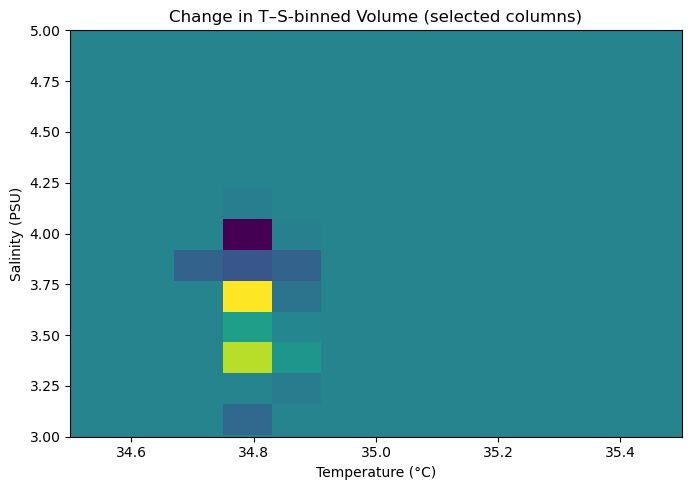

In [38]:
nT = nS = n_bins
dT_scalar = float(binsTH_edges[1] - binsTH_edges[0])   # °C
dS_scalar = float(binsSLT_edges[1] - binsSLT_edges[0]) # PSU

# Accumulate volume per T–S bin at t0 and t1 over the selected columns
Vbin0 = np.zeros((nS, nT), dtype=float)   # m^3
Vbin1 = np.zeros((nS, nT), dtype=float)   # m^3

for j, i in zip(y1d, x1d):
    # pull columns for speed
    bt0 = binned_theta_ts[0, :, j, i]
    bs0 = binned_salinity_ts[0, :, j, i]
    bt1 = binned_theta_ts[1, :, j, i]
    bs1 = binned_salinity_ts[1, :, j, i]
    V0  = vol[0, :, j, i]
    V1  = vol[1, :, j, i]

    # valid layers at each time (both bin indices finite and within range)
    ok0 = np.isfinite(bt0) & np.isfinite(bs0)
    ok1 = np.isfinite(bt1) & np.isfinite(bs1)

    # cast to int for indexing
    iT0 = bt0[ok0].astype(int); iS0 = bs0[ok0].astype(int)
    iT1 = bt1[ok1].astype(int); iS1 = bs1[ok1].astype(int)

    # accumulate m^3
    np.add.at(Vbin0, (iS0, iT0), V0[ok0])
    np.add.at(Vbin1, (iS1, iT1), V1[ok1])

# Volume tendency per bin (m^3/s), Sv
dVdt_bin_m3ps   = (Vbin1 - Vbin0) / dt
dVdt_bin_Sv     = dVdt_bin_m3ps / 1e6
dVdt_bin_SvTSp  = dVdt_bin_Sv / (dT_scalar * dS_scalar)

# If you want to store it in your existing name:
Jtendtest = dVdt_bin_Sv.copy()  # or dVdt_bin_SvTSp if you plot density

# --- quick plot (Sv) ---
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7,5))
cbar = plt.pcolormesh(Sbin,Tbin, dVdt_bin_Sv, label='dV/dt in bin (Sv)')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Salinity (PSU)')
ax.set_title('Change in T–S-binned Volume (selected columns)')
plt.tight_layout()
plt.xlim(34.5,35.5)
plt.ylim(3,5)
plt.show()


## 3) Now calculate the TS convergence of JtermsT 

In [39]:

def ts_divergence_per_process(JtermsT, JtermsS, dT=None, dS=None, bc="noflux"):
    """
    Compute TS-space divergence (i.e., inflow - outflow) for each process.
    Inputs:
      JtermsT: (nTerms, nS, nT) Sv, flux toward +T leaving each bin
      JtermsS: (nTerms, nS, nT) Sv, flux toward +S leaving each bin
      dT, dS : scalars or 1D arrays for optional normalization to Sv/(°C·PSU)
      bc     : 'noflux' (default) or 'periodic' TS boundaries
    Returns:
      Gamma_Sv      : (nTerms, nS, nT) Sv per bin
      Gamma_SvTSp   : (nTerms, nS, nT) Sv/(°C·PSU) per bin (if dT,dS given)
    """
    nTerms, nS, nT = JtermsT.shape

    # Incoming from cooler (-T) side: shift +1 in T
    if bc == "noflux":
        JT_in = np.zeros_like(JtermsT)
        JT_in[:, :, 1:] = JtermsT[:, :, :-1]
        # Incoming from fresher (-S) side: shift +1 in S
        JS_in = np.zeros_like(JtermsS)
        JS_in[:, 1:, :] = JtermsS[:, :-1, :]
    elif bc == "periodic":
        JT_in = np.roll(JtermsT, shift=1, axis=2)   # wrap in T
        JS_in = np.roll(JtermsS, shift=1, axis=1)   # wrap in S
    else:
        raise ValueError("bc must be 'noflux' or 'periodic'")

    # Outgoing to +T/+S are the given fields
    JT_out = JtermsT
    JS_out = JtermsS

    # Convergence into each bin (Sv): inflow - outflow
    Gamma_Sv = (JT_in - JT_out) + (JS_in - JS_out)

    Gamma_SvTSp = None
    if dT is not None and dS is not None:
        if np.isscalar(dT) and np.isscalar(dS):
            Gamma_SvTSp = Gamma_Sv / (dT * dS)
        else:
            # support nonuniform grids
            dT2 = dT if (hasattr(dT, "ndim") and dT.ndim == 1) else np.asarray(dT)
            dS2 = dS if (hasattr(dS, "ndim") and dS.ndim == 1) else np.asarray(dS)
            # make 2D grids to divide per-bin
            dTgrid = dT2[None, None, :] if dT2.ndim == 1 else dT2
            dSgrid = dS2[None, :, None] if dS2.ndim == 1 else dS2
            Gamma_SvTSp = Gamma_Sv / (dTgrid * dSgrid)

    return Gamma_Sv, Gamma_SvTSp


In [40]:
# J_gates is already in units of Sv/degC/PSU

In [41]:
Gamma_Sv, Gamma_SvTSp = ts_divergence_per_process(
    JtermsT, JtermsS, dT=binwidthT, dS=binwidthS, bc="noflux"
)

# Example: total convergence across all processes
Gamma_total_Sv = np.nansum(Gamma_Sv, axis=0)         # (nS, nT) Sv
Gamma_total_SvTSp = np.nansum(Gamma_SvTSp, axis=0)   # (nS, nT) Sv/(°C·PSU)

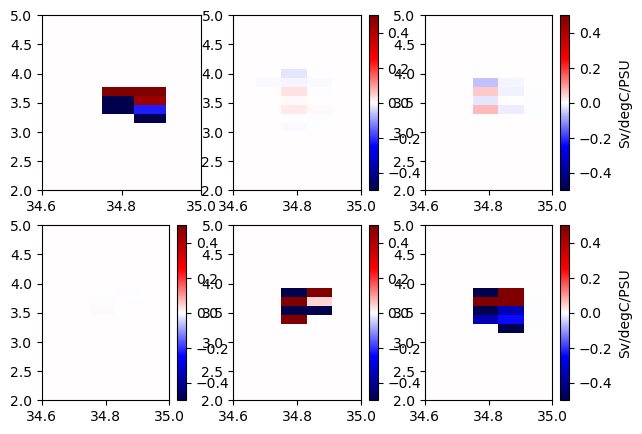

In [43]:
fig = plt.figure(figsize = (7,5))
vlev = .5

ax = plt.subplot(231)
cb = ax.pcolormesh(Sbin,Tbin,np.nansum(J_gates,axis=0),cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_xlim(34.6,35)
ax.set_ylim(2,5)

ax = plt.subplot(232)
cb = ax.pcolormesh(Sbin,Tbin,dVdt_bin_Sv,cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_xlim(34.6,35)
ax.set_ylim(2,5)
plt.colorbar(cb,label="Sv/degC/PSU")

ax = plt.subplot(233)
cb = ax.pcolormesh(Sbin,Tbin,Gamma_Sv[2],cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_xlim(34.6,35)
ax.set_ylim(2,5)
plt.colorbar(cb,label="Sv/degC/PSU")

ax = plt.subplot(234)
cb = ax.pcolormesh(Sbin,Tbin,Gamma_Sv[3],cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_xlim(34.6,35)
ax.set_ylim(2,5)
plt.colorbar(cb,label="Sv/degC/PSU")

ax = plt.subplot(235)
cb = ax.pcolormesh(Sbin,Tbin,Gamma_Sv[4],cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_xlim(34.6,35)
ax.set_ylim(2,5)
plt.colorbar(cb,label="Sv/degC/PSU")

ax = plt.subplot(236)
cb = ax.pcolormesh(Sbin,Tbin,np.nansum(Gamma_Sv[2:],axis=0) + np.nansum(J_gates,axis=0),cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_xlim(34.6,35)
ax.set_ylim(2,5)
plt.colorbar(cb,label="Sv/degC/PSU")

(2.0, 5.0)

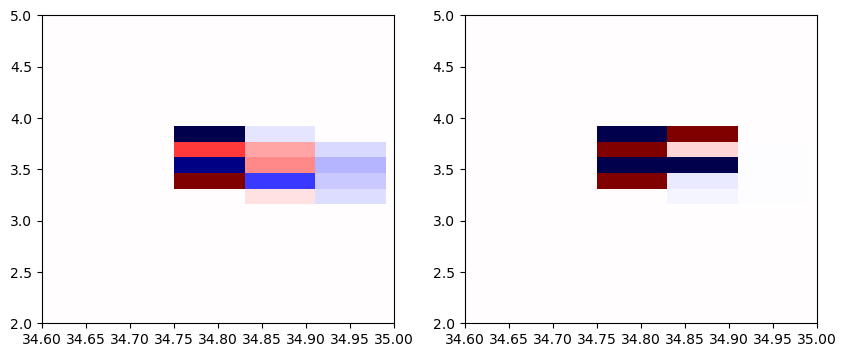

In [76]:
fig = plt.figure()

ax = plt.subplot(121)
cb = ax.pcolormesh(Sbin,Tbin,Gamma_Sv[0],cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_xlim(34.6,35)
ax.set_ylim(2,5)

ax = plt.subplot(122)
cb = ax.pcolormesh(Sbin,Tbin,np.nansum(Gamma_Sv[2:],axis=0) + np.nansum(J_gates,axis=0),cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_xlim(34.6,35)
ax.set_ylim(2,5)

(2.0, 5.0)

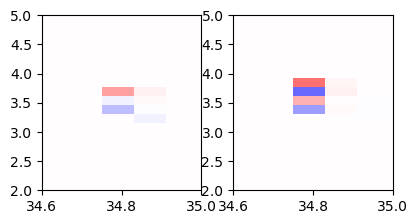

In [77]:
fig = plt.figure(figsize = (7,5))
vlev = .5

ax = plt.subplot(231)
cb = ax.pcolormesh(Sbin,Tbin,np.nansum(J_gates,axis=0),cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_xlim(34.6,35)
ax.set_ylim(2,5)

ax = plt.subplot(232)
cb = ax.pcolormesh(Sbin,Tbin,Gamma_Sv[1],cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_xlim(34.6,35)
ax.set_ylim(2,5)